Iteration 1 ---
Updating P...
Updating W...
Calculating loss...
Iteration 2 ---
Updating P...
Updating W...
Calculating loss...
Iteration 3 ---
Updating P...
Updating W...
Calculating loss...
Iteration 4 ---
Updating P...
Updating W...
Calculating loss...
Iteration 5 ---
Updating P...
Updating W...
Calculating loss...
Iteration 6 ---
Updating P...
Updating W...
Calculating loss...
Iteration 7 ---
Updating P...
Updating W...
Calculating loss...
Iteration 8 ---
Updating P...
Updating W...
Calculating loss...
Iteration 9 ---
Updating P...
Updating W...
Calculating loss...
Iteration 10 ---
Updating P...
Updating W...
Calculating loss...
Iteration 11 ---
Updating P...
Updating W...
Calculating loss...
Iteration 12 ---
Updating P...
Updating W...
Calculating loss...
Iteration 13 ---
Updating P...
Updating W...
Calculating loss...
Iteration 14 ---
Updating P...
Updating W...
Calculating loss...
Iteration 15 ---
Updating P...
Updating W...
Calculating loss...
Iteration 16 ---
Updating P...
Upd

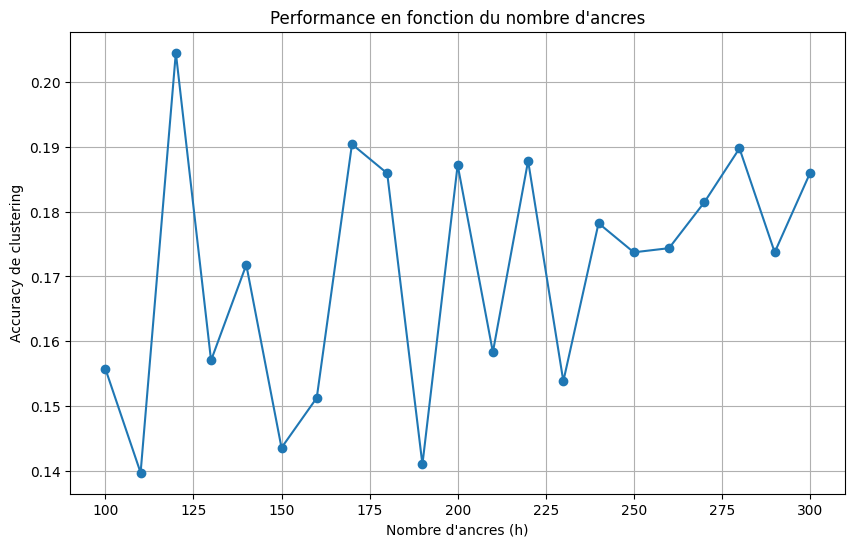

In [1]:

import numpy as np
from scipy.linalg import eigh, pinv 

from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")
def normalize(X):
    return (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)
def Lap(S):
    D = np.diag(np.sum(S, axis=1))
    return D - S
def get_Bipartite(X, h, mode=1):
    n = X.shape[1]
    idx = np.random.choice(n, h, replace=False)
    return X[:, idx]





def BGLR(X, k, m, h, beta, eta, maxIter):
    d, n = X.shape
    W = np.random.rand(d, m)
    P = np.zeros((n, h))
    lossFun = np.zeros(maxIter)
    E1 = np.zeros((n, n))
    E2 = np.zeros((h, h))
    I = np.eye(d)
    I1 = np.ones((d, d))
    di = np.zeros(n)

    featuresX = normalize(X.T)
    S1 = featuresX @ featuresX.T
    np.fill_diagonal(S1, 0)

    Z = get_Bipartite(X, h)

    for i in range(maxIter):
        print(f"Iteration {i + 1} ---")
        print("Updating P...")
        di = np.zeros(n)
        for r in range(n):
            for l in range(m):
                di[r] += np.exp(-norm(W.T @ X[:, r] - W.T @ Z[:, l])**2 / eta)
            for j in range(h):
                P[r, j] = np.exp(-norm(W.T @ X[:, r] - W.T @ Z[:, j])**2 / eta) / (di[r] + np.finfo(float).eps)

        print("Updating W...")
        new_X = np.concatenate((X, Z), axis=1)
        S = np.block([[E1, P], [P.T, E2]])
        L_S = Lap(S)
        A_X = new_X @ L_S @ new_X.T + beta * I1
        A_X[np.isnan(A_X) | np.isinf(A_X)] = 1

        # Correction pour la décomposition propre
        eigenvalues, _ = eigh(A_X)
        lambda_max = np.max(np.real(eigenvalues))
        G = lambda_max * I - A_X

        if np.linalg.matrix_rank(G) <= m:
            Q1 = np.zeros((d, k))
            idx1 = np.argsort(np.diag(G))[::-1][:k]
            for s, b in enumerate(idx1):
                Q1[b, s] = 1
            M1 = Q1.T @ G @ Q1
            # Correction pour eigh
            eigenvalues, U1 = eigh(M1)
            U1 = U1[:, -m:]  # Prendre les m derniers vecteurs propres
            W = Q1 @ U1
        else:
            loss = np.zeros(20)
            for time in range(20):
                E = G - G @ W @ pinv(W.T @ G @ W) @ W.T @ G
                Q2 = np.zeros((d, k))
                idx2 = np.argsort(np.diag(E))[::-1][:k]
                for s, b in enumerate(idx2):
                    Q2[b, s] = 1
                M2 = Q2.T @ E @ Q2
                # Correction pour eigh
                eigenvalues, U2 = eigh(M2)
                U2 = U2[:, -m:]  # Prendre les m derniers vecteurs propres
                W = np.real(Q2 @ U2)
                loss[time] = np.trace(W.T @ E @ W)

        print("Calculating loss...")
        tem1 = np.trace(W.T @ new_X @ L_S @ new_X.T @ W)
        tem2 = beta * np.trace(W.T @ I1 @ W)
        tem3 = -eta * np.sum(P * np.log(P + 1e-10))
        lossFun[i] = tem1 + tem2 + tem3

        if i > 10 and abs((lossFun[i] - lossFun[i-1]) / lossFun[i]) < 1e-5:
            break

    index = np.where(W != 0)[0]
    newfea = X[index[:k], :]
    return W, index, newfea, lossFun






from scipy.io import loadmat
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

# Vos fonctions de métriques
def clustering_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) / y_pred.size

# Charger les données
mat_data = loadmat("C:\\Users\\PC\\Desktop\\PFE-MNSA\\DATA\\Isolet.mat")

# Adapter selon structure réelle du .mat :
X = mat_data['X'].T  # (features x samples)
y_true = mat_data['Y'].flatten()  #

# Normaliser les données
X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-10)

# Paramètres BGLR
k = 50       # nombre de caractéristiques à sélectionner
m = 40       # dimension projetée
beta = 0.1
eta = 1.0
maxIter = 20

# Valeurs de h à tester
h_values = range(100, 301, 10)
accuracies = []

for h in h_values:
    # Appel de BGLR
    W, index, newfea, lossFun = BGLR(X, k, m, h, beta, eta, maxIter)
    
    # Transposer les features sélectionnées pour clustering (samples x features)
    X_selected = newfea.T
    
    # Clustering
    n_clusters = len(np.unique(y_true))
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    y_pred = kmeans.fit_predict(X_selected)
    
    # Calcul de l'accuracy
    acc = clustering_accuracy(y_true, y_pred)
    accuracies.append(acc)
    print(f"h = {h}, Accuracy = {acc:.4f}")

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(h_values, accuracies, marker='o')
plt.xlabel('Nombre d\'ancres (h)')
plt.ylabel('Accuracy de clustering')
plt.title('Performance en fonction du nombre d\'ancres')
plt.grid(True)
plt.show()